In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from cmdstanpy import CmdStanModel
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
from tqdm import tqdm

In [2]:
### Get data per country
pf8_calls = pd.read_csv('./pf8_cnv_sampledata.txt', sep = '\t')

def get_country_calls(country, gene, min_threshold):
    country_dups = pf8_calls.loc[
    (pf8_calls['Country'] == country) &
    (pf8_calls[f'{gene}_final_amplification_call'] != -1)
    ]
    long_country_data = country_dups.groupby("Year")[f'{gene}_final_amplification_call'].apply(lambda x: pd.Series({
    "ratio": sum(x == 1) / sum(x != -1),
    "cnv_gt_1": sum(x == 1),
    "cnv_gt_0_1": sum(x != -1),
    #"total": sum(x == 1) + sum(x != -1)
    })).unstack().reset_index().astype({"Year": int, "cnv_gt_1": int, "cnv_gt_0_1": int})
    mask_country = (long_country_data['cnv_gt_0_1'] > min_threshold)
    long_country_data = long_country_data[mask_country]
    
    return long_country_data

thai_mdr1 = get_country_calls('Thailand', 'MDR1', min_threshold=0)
myan_mdr1 = get_country_calls('Myanmar', 'MDR1', min_threshold = 0)
cambodia_mdr1 = get_country_calls('Cambodia', 'MDR1', min_threshold = 0)
vietnam_mdr1 = get_country_calls('Vietnam', 'MDR1', min_threshold = 0)
laos_mdr1 = get_country_calls('Laos', 'MDR1', min_threshold = 0)

thai_pm2 = get_country_calls('Thailand', 'PM2_PM3', min_threshold=0)
myan_pm2 = get_country_calls('Myanmar', 'PM2_PM3', min_threshold = 0)
cambodia_pm2 = get_country_calls('Cambodia', 'PM2_PM3', min_threshold = 0)
vietnam_pm2 = get_country_calls('Vietnam', 'PM2_PM3', min_threshold = 0)
laos_pm2 = get_country_calls('Laos', 'PM2_PM3', min_threshold = 0)

In [3]:
###Write data to stan file

def write_data(df, title):
    samples = df['cnv_gt_0_1'].to_list()
    pos = df['cnv_gt_1'].to_list()
    with open(f'./{title}_data.json', 'w') as outfile:
        outfile.write('{\n')
        outfile.write(f'"K" : {str(len(df))},\n')
        outfile.write(f'"n_k" : {samples},\n')
        outfile.write(f'"y_k" : {pos}\n')

        outfile.write('}\n')

country_data_list = ["thai_mdr1", "myan_mdr1", "cambodia_pm2", "laos_pm2"]
write_data(thai_mdr1, country_data_list[0])
write_data(myan_mdr1, country_data_list[1])
write_data(cambodia_pm2, country_data_list[2])
write_data(laos_pm2, country_data_list[3])


In [4]:
###Run Stan model
model = CmdStanModel(stan_file="./ar1_binomial.stan")

post_dict = {}
for country_data in country_data_list:
    data_file = f'./{country_data}_data.json'

    fit = model.sample(data=data_file, 
                    chains=4, 
                    parallel_chains=4, 
                    iter_warmup=1000, 
                    iter_sampling=1000, 
                    seed=123,
                    adapt_delta=.98)
    print(fit.summary)

    posterior = fit.draws_pd()

    post_dict[country_data] = posterior

#Get posterior summary statistics
def get_post_stats(posterior):
    p_means = []
    post_05s = []
    post_95s = []
    for p_k in posterior:
        if p_k[:3] == 'p_k':
            post_list = sorted(posterior[p_k].to_list())
            post_05 = post_list[int(len(post_list)*.025)]
            post_95 = post_list[int(len(post_list)*.975)]

            p_means.append((np.mean(post_list)))
            post_05s.append(post_05)
            post_95s.append(post_95)
    return p_means, post_05s, post_95s

post_dict_stats = {}

for key in post_dict.keys():
    post_dict_stats[key] = get_post_stats(post_dict[key])


17:10:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:10:12 - cmdstanpy - INFO - CmdStan done processing.
17:10:12 - cmdstanpy - INFO - CmdStan start processing



<bound method CmdStanMCMC.summary of CmdStanMCMC: model=ar1_binomial chains=4['method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.98']
 csv_files:
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialh4p68ql6/ar1_binomial-20251217171011_1.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialh4p68ql6/ar1_binomial-20251217171011_2.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialh4p68ql6/ar1_binomial-20251217171011_3.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialh4p68ql6/ar1_binomial-20251217171011_4.csv
 output_files:
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialh4p68ql6/ar1_binomial-20251217171011_0-stdout.txt
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialh4p68ql6/ar1_binomial-20251217171011_1-stdout.txt
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_bin

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:10:12 - cmdstanpy - INFO - CmdStan done processing.
17:10:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: binomial_logit_lpmf: Probability parameter[1] is -inf, but must be finite! (in 'ar1_binomial.stan', line 27, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!
17:10:12 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
17:10:12 - cmdstanpy - INFO - CmdStan start processing



<bound method CmdStanMCMC.summary of CmdStanMCMC: model=ar1_binomial chains=4['method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.98']
 csv_files:
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialm32ycq9d/ar1_binomial-20251217171012_1.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialm32ycq9d/ar1_binomial-20251217171012_2.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialm32ycq9d/ar1_binomial-20251217171012_3.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialm32ycq9d/ar1_binomial-20251217171012_4.csv
 output_files:
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialm32ycq9d/ar1_binomial-20251217171012_0-stdout.txt
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialm32ycq9d/ar1_binomial-20251217171012_1-stdout.txt
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_bin

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:10:13 - cmdstanpy - INFO - CmdStan done processing.
17:10:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: binomial_logit_lpmf: Probability parameter[1] is -inf, but must be finite! (in 'ar1_binomial.stan', line 27, column 4 to column 36)
Exception: binomial_logit_lpmf: Probability parameter[1] is -inf, but must be finite! (in 'ar1_binomial.stan', line 27, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!
17:10:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
17:10:13 - cmdstanpy - INFO - CmdStan start processing



<bound method CmdStanMCMC.summary of CmdStanMCMC: model=ar1_binomial chains=4['method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.98']
 csv_files:
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialofja8y8k/ar1_binomial-20251217171012_1.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialofja8y8k/ar1_binomial-20251217171012_2.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialofja8y8k/ar1_binomial-20251217171012_3.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialofja8y8k/ar1_binomial-20251217171012_4.csv
 output_files:
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialofja8y8k/ar1_binomial-20251217171012_0-stdout.txt
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialofja8y8k/ar1_binomial-20251217171012_1-stdout.txt
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_bin

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:10:15 - cmdstanpy - INFO - CmdStan done processing.
17:10:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: binomial_logit_lpmf: Probability parameter[1] is -inf, but must be finite! (in 'ar1_binomial.stan', line 27, column 4 to column 36)
Exception: binomial_logit_lpmf: Probability parameter[1] is -inf, but must be finite! (in 'ar1_binomial.stan', line 27, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!
17:10:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 6 divergent transitions (0.6%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 8 divergent transitions (0.8%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.



<bound method CmdStanMCMC.summary of CmdStanMCMC: model=ar1_binomial chains=4['method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.98']
 csv_files:
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialgl3qfspl/ar1_binomial-20251217171013_1.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialgl3qfspl/ar1_binomial-20251217171013_2.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialgl3qfspl/ar1_binomial-20251217171013_3.csv
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialgl3qfspl/ar1_binomial-20251217171013_4.csv
 output_files:
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialgl3qfspl/ar1_binomial-20251217171013_0-stdout.txt
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_binomialgl3qfspl/ar1_binomial-20251217171013_1-stdout.txt
	/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/tmprh6ytlcm/ar1_bin

/Users/jmarglou/mambaforge/envs/cmdstan/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


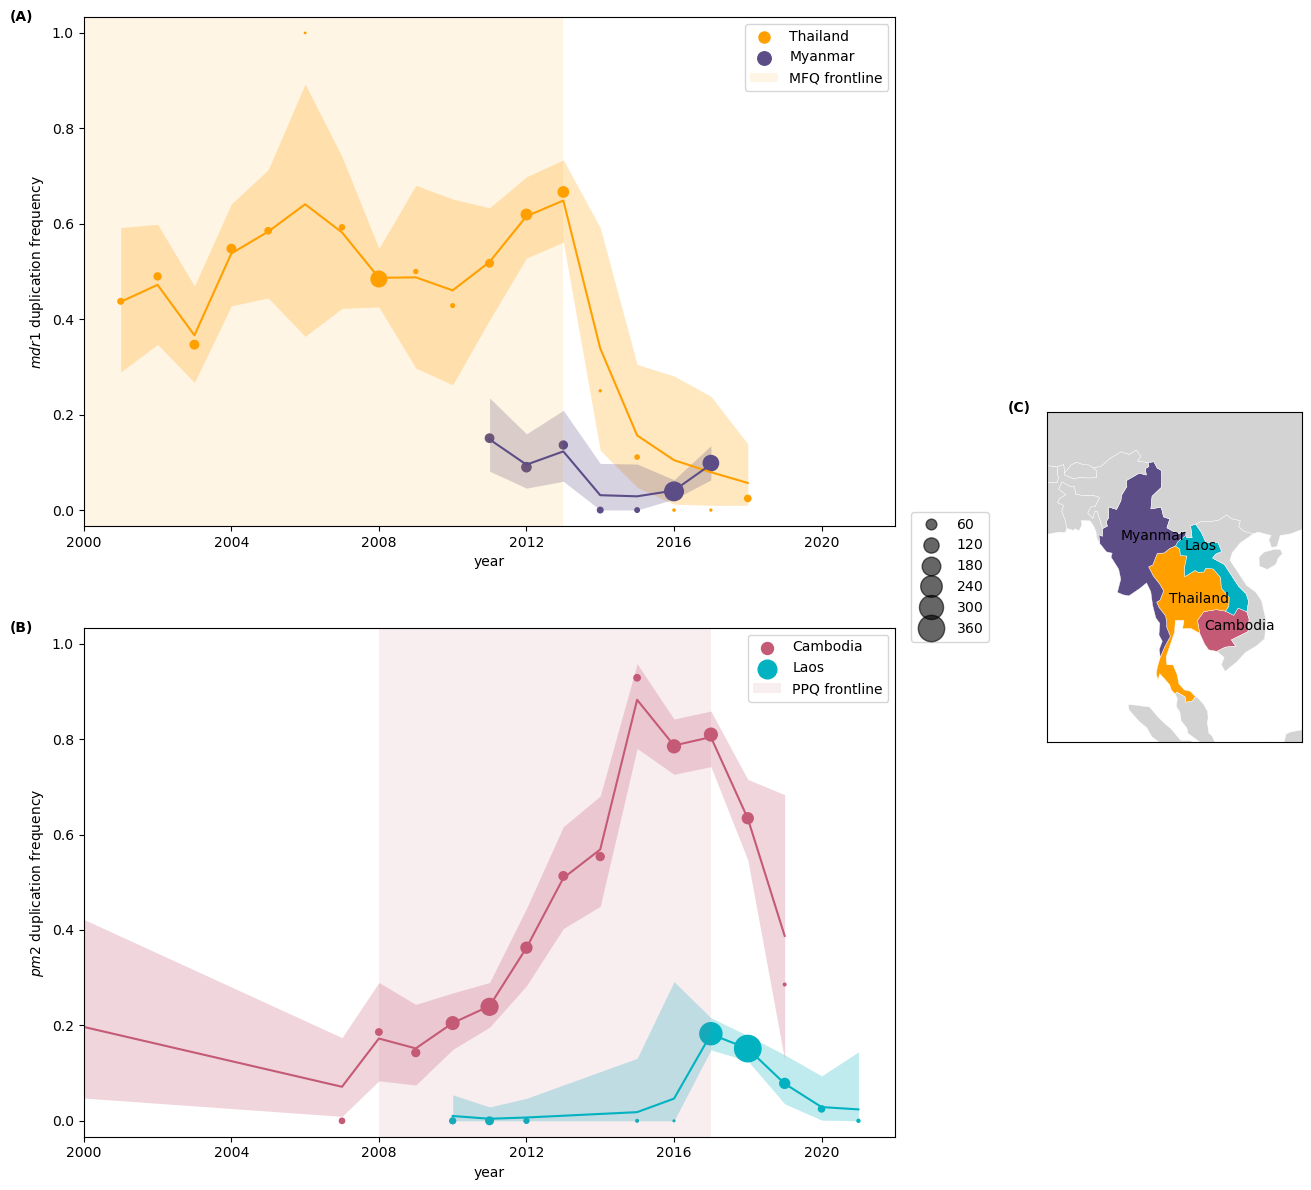

In [5]:
### Figure 1 -- data analysis
xscale = 2.5
yscale = 2.5

fig = plt.figure(tight_layout = True,
                 figsize = [6.4*xscale, 4.8*yscale])

gs0 = gridspec.GridSpec(1, 2, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[0, :])
ax2 = fig.add_subplot(gs00[1, :])

gs01 = gs0[1].subgridspec(3, 1)

ax3 = fig.add_subplot(gs01[1, :])

ax1.scatter(thai_mdr1['Year'], thai_mdr1['ratio'], label = 'Thailand', s = thai_mdr1['cnv_gt_0_1']/2, c= '#ffa000')
ax1.plot(thai_mdr1['Year'], post_dict_stats['thai_mdr1'][0], c = '#ffa000')
ax1.fill_between(thai_mdr1['Year'], post_dict_stats['thai_mdr1'][1], post_dict_stats['thai_mdr1'][2], color = '#ffa000', alpha = .25, linewidth = 0)

ax1.scatter(myan_mdr1['Year'], myan_mdr1['ratio'], label = 'Myanmar', s= myan_mdr1['cnv_gt_0_1']/2, c = '#5d4d87')
ax1.plot(myan_mdr1['Year'], post_dict_stats['myan_mdr1'][0], c = '#5d4d87')
ax1.fill_between(myan_mdr1['Year'], post_dict_stats['myan_mdr1'][1], post_dict_stats['myan_mdr1'][2], color = '#5d4d87', alpha = .25, linewidth = 0)

#ax1.scatter(cambodia_mdr1['Year'], cambodia_mdr1['ratio'], label = 'Cambodia', s= cambodia_mdr1['total'])
#ax1.scatter(vietnam_mdr1['Year'], vietnam_mdr1['ratio'], label = 'Vietnam', s = vietnam_mdr1['total'])
#ax1.scatter(laos_mdr1['Year'], laos_mdr1['ratio'], label = 'Laos', s = laos_mdr1['total'])

ax1.axvspan(xmin = 2000, 
           xmax = 2013, 
           color = '#ffa000', 
           lw = 0,
           alpha = .1, 
           label = 'MFQ frontline')
ax1.set(
    xlim = [2005, 2022],
    ylim = [-0.03333333333333333, 1.0333333333],
    xticks = np.arange(2000, 2022, 4),
    xticklabels = np.arange(2000, 2022, 4),
    xlabel = 'year',
    ylabel = '$mdr1$ duplication frequency'
    
)
ax1.legend()

#ax2.scatter(thai_pm2['Year'], thai_pm2['ratio'], label = 'Thailand', s = thai_pm2['total'])
#ax2.scatter(myan_pm2['Year'], myan_pm2['ratio'], label = 'Myanmar', s= myan_pm2['total'])
ax2.scatter(cambodia_pm2['Year'], cambodia_pm2['ratio'], label = 'Cambodia', s = cambodia_pm2['cnv_gt_0_1']/2, c = '#c45a75')
ax2.plot(cambodia_pm2['Year'], post_dict_stats['cambodia_pm2'][0], c = '#c45a75')
ax2.fill_between(cambodia_pm2['Year'], post_dict_stats['cambodia_pm2'][1], post_dict_stats['cambodia_pm2'][2], color = '#c45a75', alpha = .25, linewidth = 0)

#ax2.scatter(vietnam_pm2['Year'], vietnam_pm2['ratio'], label = 'Vietnam', s = vietnam_pm2['total'], c= '#E9C46A')
sc = ax2.scatter(laos_pm2['Year'], laos_pm2['ratio'], label = 'Laos', s = laos_pm2['cnv_gt_0_1']/2, c = '#02b2c1')
ax2.plot(laos_pm2['Year'], post_dict_stats['laos_pm2'][0], c = '#02b2c1')
ax2.fill_between(laos_pm2['Year'], post_dict_stats['laos_pm2'][1], post_dict_stats['laos_pm2'][2], color = '#02b2c1', alpha = .25, linewidth = 0)

ax2.axvspan(xmin = 2008, 
           xmax = 2017, 
           color = '#c45a75', 
           lw = 0,
           alpha = .1, 
           label = 'PPQ frontline')
ax2.set(
    xlim = [2001, 2022],
    ylim = [-0.03333333333333333, 1.0333333333],
    xticks = np.arange(2000, 2022, 4),
    xticklabels = np.arange(2000, 2022, 4),
    xlabel = 'year',
    ylabel = '$pm2$ duplication frequency'
    
)
ax2.legend()

world = gpd.read_file('/Users/jmarglou/documents/bailey_lab/projects/cnv_inference/mip_cnv_inference/data/meta/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
asia = world[world['CONTINENT'] == 'Asia']
asia.to_string()
asia['color'] = 1

colormap = ListedColormap(colors = ['lightgrey', "#ffa000", "#5d4d87", "#c45a75", "#02b1c1"])
data_countries = ['Thailand', 'Myanmar', 'Cambodia', 'Laos']

asia.loc[asia['SOVEREIGNT'].isin(['Thailand']), 'color'] = 2
asia.loc[asia['SOVEREIGNT'].isin(['Myanmar']), 'color'] = 3
asia.loc[asia['SOVEREIGNT'].isin(['Cambodia']), 'color'] = 4
asia.loc[asia['SOVEREIGNT'].isin(['Laos']), 'color'] = 5

asia.plot(column = 'color', cmap = colormap, edgecolor = 'white', linewidth = .3, ax = ax3)

#legend_element = [Patch(facecolor='tab:green',
                         #label='MIP data available')]

#ax.legend(handles = legend_element)

ax3.set(xlim = [87, 113], 
       ylim = [2, 33], 
       xticks = [], 
       yticks = []
       )

# arrow_offset = 0
# ax3.annotate('', xytext = (107, 12.75), xy = (106+arrow_offset, 16), arrowprops = dict(arrowstyle = '<-', connectionstyle = 'arc3,rad=.5', 
#                                                                                                     color = "#026069", 
#                                                                                                     linewidth = 4))
# ax3.annotate('', xytext = (106+arrow_offset, 16), xy = (106.5+arrow_offset, 13), arrowprops = dict(arrowstyle = '<-', connectionstyle = 'arc3,rad=.5', 
#                                                                                                      color = "#4E242F", 
#                                                                                                      linewidth = 4))

ax3.annotate('Myanmar', xy = (94.5, 21), xytext = (94.5, 21), color = "black")
ax3.annotate('Thailand', xy = (99.5, 15))
ax3.annotate('Cambodia', xy = (103, 12.5))
ax3.annotate('Laos', xy = (101, 20))

#ax3.set(xticks = [], yticks = [])

ax1.text(s = '(A)', x = 1998, y = 1.025, fontweight = 'bold')
ax2.text(s = '(B)', x = 1998, y = 1.025, fontweight = 'bold')
ax3.text(s = '(C)', x = 83, y = 33, fontweight = 'bold')


handles, labels = sc.legend_elements(prop="sizes", num=6, alpha=0.6)

# Add the legend to the axes
ax3.legend(handles, labels, loc = 'center right', bbox_to_anchor = (-.2, .5))

fig.savefig('./figures/mdr1_temporal_frequency_thaivsmyan.png', dpi = 400)


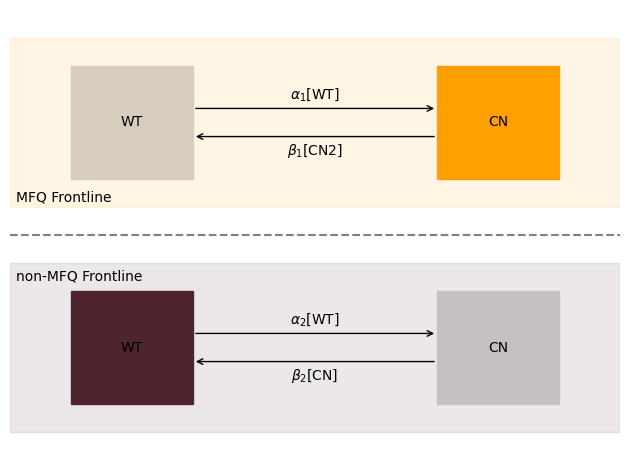

In [6]:
### Figure 2 -- model specification
def get_loc(obj):
    bottom_left = obj.get_corners()[0]
    top_right= obj.get_corners()[2]
    height_avg = (bottom_left[1] + top_right[1])/2
    width_avg = (bottom_left[0] + top_right[0])/2
    return [width_avg, height_avg]

def make_txt(obj, txt, ax):
    loc = get_loc(obj)
    ax.text(loc[0], loc[1], 
        txt,
        ha = 'center',
        va = 'center')
    
fig = plt.figure(tight_layout = True, figsize = [6.4, 4.8])
ax = fig.add_subplot(1,1, 1)

width = .1
height = .1
center = .5
color = 'dodgerblue'
offset = .0125

WT = patches.Rectangle(
    xy = (.2 -.5*height, center - .5*height),
    width = width,
    height = height,
    edgecolor = 'lightgrey',
    facecolor = 'lightgrey',
    alpha = 1
)
ax.add_patch(WT)
make_txt(WT, 'WT', ax)

CN2 = patches.Rectangle(
    xy = (.5 -.5*width, center - .5*height),
    width = width,
    height = height,
    edgecolor = '#ffa000',
    facecolor = '#ffa000',
    alpha = 1
)

ax.add_patch(CN2)
make_txt(CN2, 'CN', ax)

#WT<-> CN2
wt_loc = get_loc(WT)
cn2_loc = get_loc(CN2)
ax.annotate("", xytext=(wt_loc[0] + .5*width, wt_loc[1]+offset), xy=(cn2_loc[0]-.5*width, cn2_loc[1]+offset),
            arrowprops=dict(arrowstyle="->"))
ax.text(x = (wt_loc[0] + .5*width + cn2_loc[0]-.5*width)/2, 
        y = cn2_loc[1]+2*offset,
        s = rf'$\alpha_1$[WT]',
        ha = 'center',
        va = 'center')

ax.annotate("", xytext=(wt_loc[0] + .5*width, wt_loc[1]-offset), xy=(cn2_loc[0]-.5*width, cn2_loc[1]-offset),
            arrowprops=dict(arrowstyle="<-"))
ax.text(x = (wt_loc[0] + .5*width + cn2_loc[0]-.5*width)/2, 
        y = cn2_loc[1]-2*offset,
        s = rf'$\beta_1$[CN2]',
        ha = 'center',
        va = 'center')

WT2 = patches.Rectangle(
    xy = (.2 -.5*height, center -.2 -.5*height),
    width = width,
    height = height,
    edgecolor = '#4E242F',
    facecolor = '#4E242F',
    alpha = 1
)
ax.add_patch(WT2)
make_txt(WT2, 'WT', ax)

CN2_2 = patches.Rectangle(
    xy = (.5 -.5*width, center - .2 - .5*height),
    width = width,
    height = height,
    edgecolor = 'lightgrey',
    facecolor = 'lightgrey',
    alpha = 1
)

#WT2<-> CN2_2
wt2_loc = get_loc(WT2)
cn2_2_loc = get_loc(CN2_2)
ax.annotate("", xytext=(wt2_loc[0] + .5*width, wt2_loc[1]+offset), xy=(cn2_2_loc[0]-.5*width, cn2_2_loc[1]+offset),
            arrowprops=dict(arrowstyle="->"))
ax.text(x = (wt2_loc[0] + .5*width + cn2_2_loc[0]-.5*width)/2, 
        y = cn2_2_loc[1]+2*offset,
        s = rf'$\alpha_2$[WT]',
        ha = 'center',
        va = 'center')

ax.annotate("", xytext=(wt2_loc[0] + .5*width, wt2_loc[1]-offset), xy=(cn2_2_loc[0]-.5*width, cn2_2_loc[1]-offset),
            arrowprops=dict(arrowstyle="<-"))
ax.text(x = (wt2_loc[0] + .5*width + cn2_2_loc[0]-.5*width)/2, 
        y = cn2_2_loc[1]-2*offset,
        s = rf'$\beta_2$[CN]',
        ha = 'center',
        va = 'center')
ax.add_patch(CN2_2)
make_txt(CN2_2, 'CN', ax)

ax.axhline(y = .4, linestyle = 'dashed', color = 'grey')
#ax1.spines['top'].set_visible(False)
#ax1.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set(
        xticks = [],
        yticks = [], 
        xticklabels = [],
        yticklabels = [],
        xlim = [.1, .6],
        ylim = [.2, .6]
)

drug = patches.Rectangle(
    xy = (.1, .425),
    width = .6-.1,
    height = .575-.425,
    edgecolor = '#ffa000',
    facecolor = '#ffa000',
    alpha = .1
)
ax.add_patch(drug)

no_drug = patches.Rectangle(
    xy = (.1, .225),
    width = .6-.1,
    height = .375-.225,
    edgecolor = '#4E242F',
    facecolor = '#4E242F',
    alpha = .1
)
ax.add_patch(no_drug)

ax.text(s = 'MFQ Frontline', x = .105, y = .43)
ax.text(s = 'non-MFQ Frontline', x = .105, y = .36)

fig.savefig('./figures/cnv_dag.png', dpi = 400)

#ax1.text(s = '(A)', x = 1997, y = 1, fontweight = 'bold', fontsize = 12)
#ax.text(s = '(B)', x = -.1, y = .8, fontweight = 'bold', fontsize = 12)

In [7]:
### Fig 3 -- fit model

####Define model
def cnv_compartment(t, z, a_1, a_2):
    W, C = z
    return [a_2*C-a_1*W, a_1*W-a_2*C]

####Define range of parameters to test
t_min = 0
t_max = 13
t = np.arange(t_min, t_max, 1)

init_Ws = np.arange(0, 1, .1)
trans_W_Cs = np.arange(0, 1, .01)
trans_C_Ws = np.arange(0, 1, .01)

#####Fit for portion of time with drug
time_vals = []
sqdiff_vals = []
params = []
for init_W in tqdm(init_Ws):
    init_C = 1- init_W
    for trans_W_C in trans_W_Cs:
        for trans_C_W in trans_C_Ws:
            sol_drug = solve_ivp(cnv_compartment, [t_min, t_max], [init_W, init_C], args=(trans_W_C, trans_C_W),
                dense_output=True)
            
            z = sol_drug.sol(t)
            time_vals.append(z[1])

            sq_diff = np.sum((z[1]-post_dict_stats['thai_mdr1'][0][:13])**2)
            sqdiff_vals.append(sq_diff)
            params.append([init_W, init_C, trans_W_C, trans_C_W])

#####Fit for portion of time post drug, starting with ending conditions of drug
optim_i = int(np.argmin(sqdiff_vals))
opt_params = params[optim_i]

init_W_nodrug = 1- time_vals[optim_i][-1]
init_C_nodrug = time_vals[optim_i][-1]
trans_W_Cs_nodrug = np.arange(0, 1, .01)
trans_C_Ws_nodrug = np.arange(0, 1, .01)

time_vals_nodrug = []
sqdiff_vals_nodrug = []
params_nodrug = []

t_min_nodrug = 0
t_max_nodrug = 6
t = np.arange(t_min_nodrug, t_max_nodrug, 1)

time_vals_nodrug = []
sqdiff_vals_nodrug= []
params_nodrug = []
for trans_W_C_nodrug in tqdm(trans_W_Cs_nodrug):
    for trans_C_W_nodrug in trans_C_Ws_nodrug:
        sol_nodrug = solve_ivp(cnv_compartment, [t_min_nodrug, t_max_nodrug], [init_W_nodrug, init_C_nodrug], args=(trans_W_C_nodrug, trans_C_W_nodrug),
            dense_output=True)
        
        z_nodrug = sol_nodrug.sol(t)
        time_vals_nodrug.append(z_nodrug[1])

        sq_diff_nodrug = np.sum((z_nodrug[1]-post_dict_stats['thai_mdr1'][0][12:])**2)
        sqdiff_vals_nodrug.append(sq_diff_nodrug)
        params_nodrug.append([init_W_nodrug, init_C_nodrug, trans_W_C_nodrug, trans_C_W_nodrug])

optim_i_nodrug = int(np.argmin(sqdiff_vals_nodrug))
opt_params_nodrug = params_nodrug[optim_i_nodrug]


100%|██████████| 100/100 [00:02<00:00, 37.39it/s]


In [8]:
### Fig 3 -- fit model

####Repeat for Myanmar

#####Define range of parameters to test
t_min_m = 0
t_max_m = 7
t_m = np.arange(t_min_m, t_max_m, 1)

init_Ws_m = np.arange(0, 1, .1)
trans_W_Cs_m = np.arange(0, 1, .01)
trans_C_Ws_m = np.arange(0, 1, .01)

#####Fit for single time without drug 
time_vals_m = []
sqdiff_vals_m = []
params_m  = []
for init_W_m in tqdm(init_Ws_m):
    init_C_m = 1- init_W_m
    for trans_W_C_m in trans_W_Cs_m:
        for trans_C_W_m in trans_C_Ws_m:
            sol_drug = solve_ivp(cnv_compartment, [t_min_m, t_max_m], [init_W_m, init_C_m], args=(trans_W_C_m, trans_C_W_m),
                dense_output=True)
            
            z_m = sol_drug.sol(t_m)
            time_vals_m.append(z_m[1])

            sq_diff_m = np.sum((z_m[1]-post_dict_stats['myan_mdr1'][0])**2)
            sqdiff_vals_m.append(sq_diff_m)
            params_m.append([init_W_m, init_C_m, trans_W_C_m, trans_C_W_m])

optim_i_m = int(np.argmin(sqdiff_vals_m))
opt_params_m = params_m[optim_i_m]





100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


In [ ]:
#Organize least squares vals for Thailand with drug
X, Y = np.meshgrid(trans_W_Cs, trans_C_Ws)

LS_vals = np.zeros([100, 100])

for i in tqdm(range(X.shape[0])):
    for j in range(Y.shape[1]):
        for k in range(len(params)):
            if params[k][0] == opt_params[0] and params[k][1] == opt_params[1]:
                if params[k][2] == X[i, j] and params[k][3] == Y[i, j]:
                    LS_vals[i, j] = sqdiff_vals[k]

100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


In [ ]:
#Organize least squares vals for Thailand without drug
X_nd, Y_nd = np.meshgrid(trans_W_Cs, trans_C_Ws)

LS_vals_nd = np.zeros([100, 100])

for i in tqdm(range(X.shape[0])):
    for j in range(Y.shape[1]):
        for k in range(len(params_nodrug)):
            if params_nodrug[k][0] == opt_params_nodrug[0] and params_nodrug[k][1] == opt_params_nodrug[1]:
                if params_nodrug[k][2] == X_nd[i, j] and params_nodrug[k][3] == Y_nd[i, j]:
                    LS_vals_nd[i, j] = sqdiff_vals_nodrug[k]

100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


In [ ]:
##Organize least squares vals for Myanmar
X_m, Y_m = np.meshgrid(trans_W_Cs, trans_C_Ws)

LS_vals_m = np.zeros([100, 100])

for i in tqdm(range(X.shape[0])):
    for j in range(Y.shape[1]):
        for k in range(len(params_m)):
            if params_m[k][0] == opt_params_m[0] and params_m[k][1] == opt_params_m[1]:
                if params_m[k][2] == X_m[i, j] and params_m[k][3] == Y_m[i, j]:
                    LS_vals_m[i, j] = sqdiff_vals_m[k]

100%|██████████| 100/100 [01:28<00:00,  1.14it/s]


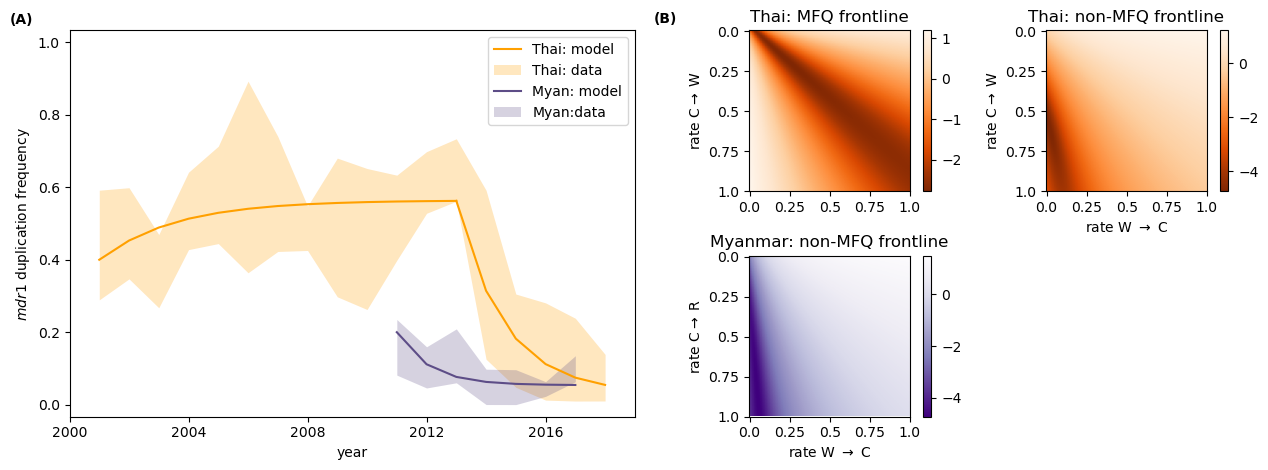

In [18]:
### Plot figure

fig = plt.figure(figsize = [6.4*2, 4.8], 
                 tight_layout = True
                 )
gs0 = gridspec.GridSpec(1, 2, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
gs01 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[1])

ax = fig.add_subplot(gs00[:, :])
ax1 = fig.add_subplot(gs01[0, 0])
ax2 = fig.add_subplot(gs01[0, 1])
ax3 = fig.add_subplot(gs01[1, 0])

#Plot fitted model
##Thai, with drug
ax.plot(np.arange(2001, 2019, 1)[:13], time_vals[optim_i], color = '#ffa000', label = 'Thai: model')
#Plot data
#ax.plot(np.arange(2001, 2019, 1), post_dict_stats['thai_mdr1'][0], color = 'tab:blue', alpha = .5, linewidth = 4)
ax.fill_between(thai_mdr1['Year'], post_dict_stats['thai_mdr1'][1], post_dict_stats['thai_mdr1'][2], color = '#ffa000', alpha = .25, linewidth = 0, label = 'Thai: data')
##Thai, without drug
ax.plot(np.arange(2001, 2019, 1)[12:], time_vals_nodrug[optim_i_nodrug], color = '#ffa000')
##Myan, without drug
ax.plot(np.arange(2011, 2018, 1), time_vals_m[optim_i_m], color = '#5d4d87', label = 'Myan: model')


ax.fill_between(myan_mdr1['Year'], post_dict_stats['myan_mdr1'][1], post_dict_stats['myan_mdr1'][2], color = '#5d4d87', alpha = .25, linewidth = 0, label = 'Myan:data')

ax.legend()
ax.set(
    xlim = [2000, 2019],
    ylim = [-0.03333333333333333, 1.0333333333],
    xticks = np.arange(2000, 2020, 4),
    xticklabels = np.arange(2000, 2020, 4),
    xlabel = 'year',
    ylabel = '$mdr1$ duplication frequency'
    
)

##Plot heatmap of parameter values
thai_mdr1_im = ax1.imshow(np.log(LS_vals), cmap = 'Oranges_r')
ax1.set(#xlim = [trans_W_Cs[0], trans_W_Cs[-1]],
       xticks = np.arange(0, 101, 25), 
       xticklabels = np.arange(0, 1.1, .25),
       yticks = np.arange(0, 101, 25), 
       yticklabels = np.arange(0, 1.1, .25),
        #xlabel = r'rate W $\rightarrow$ C',
        ylabel = r'rate C$\rightarrow$ W',
        title = 'Thai: MFQ frontline'

)

fig.colorbar(thai_mdr1_im, ax = ax1)
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)

thai_postmdr1_im = ax2.imshow(np.log(LS_vals_nd), cmap = 'Oranges_r')
ax2.set(#xlim = [trans_W_Cs[0], trans_W_Cs[-1]],
  xticks = np.arange(0, 101, 25), 
       xticklabels = np.arange(0, 1.1, .25),
       yticks = np.arange(0, 101, 25), 
       yticklabels = np.arange(0, 1.1, .25),
        xlabel = r'rate W $\rightarrow$ C',
       ylabel = r'rate C$\rightarrow$ W',
       title = 'Thai: non-MFQ frontline'

)
fig.colorbar(thai_postmdr1_im, ax = ax2)


myan_mdr1_im = ax3.imshow(np.log(LS_vals_m), cmap = 'Purples_r')

ax3.set(#xlim = [trans_W_Cs[0], trans_W_Cs[-1]],
      xticks = np.arange(0, 101, 25), 
       xticklabels = np.arange(0, 1.1, .25),
       yticks = np.arange(0, 101, 25), 
       yticklabels = np.arange(0, 1.1, .25),
       xlabel = r'rate W $\rightarrow$ C',
       ylabel = r'rate C$\rightarrow$ R',
       title = 'Myanmar: non-MFQ frontline'
)
fig.colorbar(myan_mdr1_im, ax = ax3)

plt.subplots_adjust(hspace=0.4)

ax.text(s = '(A)', x = 1998, y = 1.05, fontweight = 'bold')
ax1.text(s = '(B)', x = -60, y = -5, fontweight = 'bold')

fig.savefig('./figures/model_fitting.png', dpi = 300)

In [120]:
##Fig 4: visualize drug cycling

start_WT = opt_params[0]
start_CN = opt_params[1]
drug_WTtoCN = opt_params[2]
drug_CNtoWT = opt_params[3]
nodrug_WTtoCN = opt_params_nodrug[2]
nodrug_CNtoWT = opt_params_nodrug[3]

## 5 year cycles
t_min_1 = 0
t_max_1 = 6
t = np.arange(t_min_1, t_max_1, 1)

sol_drug_1 = solve_ivp(cnv_compartment, [t_min_1, t_max_1], [start_WT, start_CN], args=(drug_WTtoCN, drug_CNtoWT),
                dense_output=True)

z_m_1 = sol_drug_1.sol(t)

start_CN_2 = z_m_1[1][-1]
start_WT_2 = 1-z_m_1[1][-1]

sol_drug_2 = solve_ivp(cnv_compartment, [t_min_1, t_max_1], [start_WT_2, start_CN_2], args=(nodrug_WTtoCN, nodrug_CNtoWT),
                dense_output=True)

z_m_2 = sol_drug_2.sol(t)

start_CN_3 = z_m_2[1][-1]
start_WT_3 = 1-z_m_2[1][-1]

sol_drug_3 = solve_ivp(cnv_compartment, [t_min_1, t_max_1], [start_WT_3, start_CN_3], args=(drug_WTtoCN, drug_CNtoWT),
                dense_output=True)

z_m_3 = sol_drug_3.sol(t)

start_CN_4 = z_m_3[1][-1]
start_WT_4 = 1-z_m_3[1][-1]

sol_drug_4 = solve_ivp(cnv_compartment, [t_min_1, t_max_1], [start_WT_4, start_CN_4], args=(nodrug_WTtoCN, nodrug_CNtoWT),
                dense_output=True)

z_m_4 = sol_drug_4.sol(t)


#time_vals.append(z_m[1])


In [159]:
## 2 year cycles
t_min_1_2 = 0
t_max_1_2 = 3
t = np.arange(t_min_1_2, t_max_1_2, 1)

sol_drug_1 = solve_ivp(cnv_compartment, [t_min_1_2, t_max_1_2], [start_WT, start_CN], args=(drug_WTtoCN, drug_CNtoWT),
                dense_output=True)

z_m_1_2 = sol_drug_1.sol(t)

start_CN_2 = z_m_1_2[1][-1]
start_WT_2 = 1-z_m_1_2[1][-1]

sol_drug_2 = solve_ivp(cnv_compartment, [t_min_1_2, t_max_1_2], [start_WT_2, start_CN_2], args=(nodrug_WTtoCN, nodrug_CNtoWT),
                dense_output=True)

z_m_2_2 = sol_drug_2.sol(t)

start_CN_3 = z_m_2_2[1][-1]
start_WT_3 = 1-z_m_2_2[1][-1]

sol_drug_3 = solve_ivp(cnv_compartment, [t_min_1_2, t_max_1_2], [start_WT_3, start_CN_3], args=(drug_WTtoCN, drug_CNtoWT),
                dense_output=True)

z_m_3_2 = sol_drug_3.sol(t)

start_CN_4 = z_m_3_2[1][-1]
start_WT_4 = 1-z_m_3_2[1][-1]

sol_drug_4 = solve_ivp(cnv_compartment, [t_min_1_2, t_max_1_2], [start_WT_4, start_CN_4], args=(nodrug_WTtoCN, nodrug_CNtoWT),
                dense_output=True)

z_m_4_2 = sol_drug_4.sol(t)

start_CN_5 = z_m_4_2[1][-1]
start_WT_5 = 1-z_m_4_2[1][-1]

sol_drug_5 = solve_ivp(cnv_compartment, [t_min_1_2, t_max_1_2], [start_WT_5, start_CN_5], args=(drug_WTtoCN, drug_CNtoWT),
                dense_output=True)

z_m_5_2 = sol_drug_5.sol(t)

start_CN_6 = z_m_5_2[1][-1]
start_WT_6 = 1-z_m_5_2[1][-1]

sol_drug_6 = solve_ivp(cnv_compartment, [t_min_1_2, t_max_1_2], [start_WT_6, start_CN_6], args=(nodrug_WTtoCN, nodrug_CNtoWT),
                dense_output=True)

z_m_6_2 = sol_drug_6.sol(t)

start_CN_7 = z_m_6_2[1][-1]
start_WT_7 = 1-z_m_6_2[1][-1]

sol_drug_7 = solve_ivp(cnv_compartment, [t_min_1_2, t_max_1_2], [start_WT_7, start_CN_7], args=(drug_WTtoCN, drug_CNtoWT),
                dense_output=True)

z_m_7_2 = sol_drug_7.sol(t)

start_CN_8 = z_m_7_2[1][-1]
start_WT_8 = 1-z_m_7_2[1][-1]

sol_drug_8 = solve_ivp(cnv_compartment, [t_min_1_2, t_max_1_2], [start_WT_8, start_CN_8], args=(nodrug_WTtoCN, nodrug_CNtoWT),
                dense_output=True)

z_m_8_2 = sol_drug_8.sol(t)

start_CN_9 = z_m_8_2[1][-1]
start_WT_9 = 1-z_m_8_2[1][-1]

sol_drug_9 = solve_ivp(cnv_compartment, [t_min_1_2, t_max_1_2], [start_WT_9, start_CN_9], args=(drug_WTtoCN, drug_CNtoWT),
                dense_output=True)

z_m_9_2 = sol_drug_9.sol(t)

start_CN_10 = z_m_9_2[1][-1]
start_WT_10 = 1-z_m_9_2[1][-1]

sol_drug_10 = solve_ivp(cnv_compartment, [t_min_1_2, t_max_1_2], [start_WT_10, start_CN_10], args=(nodrug_WTtoCN, nodrug_CNtoWT),
                dense_output=True)

z_m_10_2 = sol_drug_10.sol(t)

In [193]:
start_CN

np.float64(0.3999999999999999)

In [ ]:
#Threshold-based cycles
WT_frac = [start_WT]
CN_frac = [start_CN]

up_thresh = .4
low_thresh = .1
print(len(CN_frac))
while CN_frac[-1] < up_thresh and len(CN_frac) < 100:
    WT_frac.append(WT_frac[-1] + CN_frac[-1]*drug_CNtoWT - WT_frac[-1]*drug_WTtoCN)
    CN_frac.append(CN_frac[-1] + WT_frac[-1]*drug_WTtoCN - CN_frac[-1]*drug_CNtoWT)

print(len(CN_frac))
while CN_frac[-1] > low_thresh and len(CN_frac) < 100:
    WT_frac.append(WT_frac[-1] + CN_frac[-1]*nodrug_CNtoWT - WT_frac[-1]*nodrug_WTtoCN)
    CN_frac.append(CN_frac[-1] + WT_frac[-1]*nodrug_WTtoCN - CN_frac[-1]*nodrug_CNtoWT)

print(len(CN_frac))
while CN_frac[-1] < up_thresh and len(CN_frac) < 100:
    WT_frac.append(WT_frac[-1] + CN_frac[-1]*drug_CNtoWT - WT_frac[-1]*drug_WTtoCN)
    CN_frac.append(CN_frac[-1] + WT_frac[-1]*drug_WTtoCN - CN_frac[-1]*drug_CNtoWT)

print(len(CN_frac))
while CN_frac[-1] > low_thresh and len(CN_frac) < 100:
    WT_frac.append(WT_frac[-1] + CN_frac[-1]*nodrug_CNtoWT - WT_frac[-1]*nodrug_WTtoCN)
    CN_frac.append(CN_frac[-1] + WT_frac[-1]*nodrug_WTtoCN - CN_frac[-1]*nodrug_CNtoWT)

print(len(CN_frac))
while CN_frac[-1] < up_thresh and len(CN_frac) < 100:
    WT_frac.append(WT_frac[-1] + CN_frac[-1]*drug_CNtoWT - WT_frac[-1]*drug_WTtoCN)
    CN_frac.append(CN_frac[-1] + WT_frac[-1]*drug_WTtoCN - CN_frac[-1]*drug_CNtoWT)

# print(len(CN_frac))
# while CN_frac[-1] > low_thresh or len(CN_frac) < 100:
#     WT_frac.append(WT_frac[-1] + CN_frac[-1]*nodrug_CNtoWT - WT_frac[-1]*nodrug_WTtoCN)
#     CN_frac.append(CN_frac[-1] + WT_frac[-1]*nodrug_WTtoCN - CN_frac[-1]*nodrug_CNtoWT)

# while CN_frac[-1] < up_thresh or len(CN_frac) < 100:
#     WT_frac.append(WT_frac[-1] + CN_frac[-1]*drug_CNtoWT - WT_frac[-1]*drug_WTtoCN)
#     CN_frac.append(CN_frac[-1] + WT_frac[-1]*drug_WTtoCN - CN_frac[-1]*drug_CNtoWT)

# while CN_frac[-1] > low_thresh or len(CN_frac) < 100:
#     WT_frac.append(WT_frac[-1] + CN_frac[-1]*nodrug_CNtoWT - WT_frac[-1]*nodrug_WTtoCN)
#     CN_frac.append(CN_frac[-1] + WT_frac[-1]*nodrug_WTtoCN - CN_frac[-1]*nodrug_CNtoWT)

1
4
7
100
100


In [222]:
CN_frac

[np.float64(0.3999999999999999),
 np.float64(0.44991999999999993),
 np.float64(0.4822382079999999),
 np.float64(0.5031610158591999),
 np.float64(0.21153910941082626),
 np.float64(0.10008121676625778),
 np.float64(0.057482010197503715),
 np.float64(0.2081637755966448),
 np.float64(0.30571515051604875),
 np.float64(0.3688699106388708),
 np.float64(0.4097563023423858),
 np.float64(0.43622615233124146),
 np.float64(0.45336273321402665),
 np.float64(0.4644569556775417),
 np.float64(0.47163935530042134),
 np.float64(0.47628924081627366),
 np.float64(0.4792995766992364),
 np.float64(0.48124846814986655),
 np.float64(0.4825101804750045),
 np.float64(0.48332701303429876),
 np.float64(0.48385583043318586),
 np.float64(0.4841981868172254),
 np.float64(0.48441982834025255),
 np.float64(0.48456331906226036),
 np.float64(0.4846562149556882),
 np.float64(0.4847163557570934),
 np.float64(0.4847552909119231),
 np.float64(0.48478049753115987),
 np.float64(0.48479681629645377),
 np.float64(0.484807381065

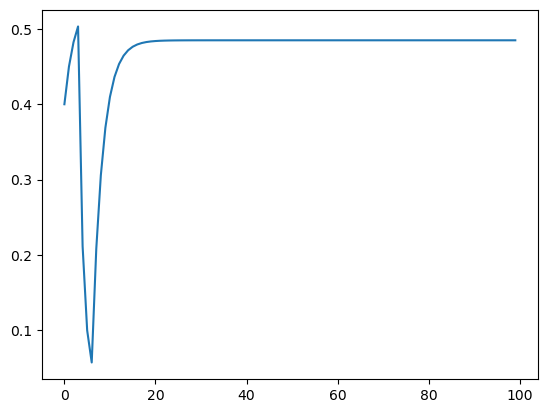

In [223]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(CN_frac[:200])), CN_frac[:200])

In [197]:
CN_frac

[np.float64(0.3999999999999999),
 np.float64(0.44991999999999993),
 np.float64(0.4822382079999999),
 np.float64(0.5031610158591999),
 np.float64(0.516706441667246),
 np.float64(0.525475750335375),
 np.float64(0.5311530007671217),
 np.float64(0.5348284526966346),
 np.float64(0.5372079402758012),
 np.float64(0.5387484205345536),
 np.float64(0.53974572745407),
 np.float64(0.5403913839537648),
 np.float64(0.5408093819716673),
 np.float64(0.5410799938884574),
 np.float64(0.5412551880433872),
 np.float64(0.5413686087392888),
 np.float64(0.5414420372978156),
 np.float64(0.5414895749466058),
 np.float64(0.5415203508204326),
 np.float64(0.541540275121148),
 np.float64(0.5415531741134312),
 np.float64(0.5415615249210353),
 np.float64(0.5415669312338782),
 np.float64(0.5415704312808127),
 np.float64(0.5415726972111982),
 np.float64(0.5415741641745297),
 np.float64(0.5415751138865905),
 np.float64(0.5415757287301787),
 np.float64(0.5415761267799176),
 np.float64(0.5415763844773186),
 np.float64(0.

[(0.0, 1.0),
 Text(0, 0.5, '$mdr1$ duplication frequency'),
 Text(0.5, 0, 'time (years)'),
 Text(0.5, 1.0, '2-year drug cycles')]

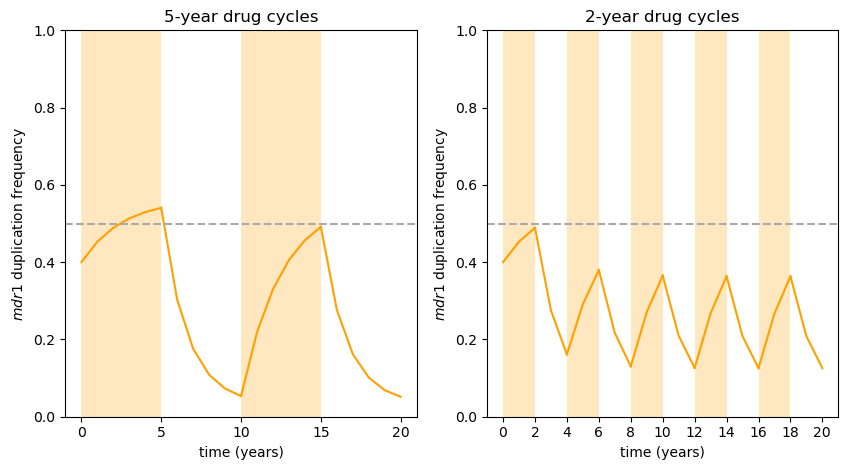

In [160]:
fig = plt.figure(tight_layout = True, figsize = [6.4*2, 4.8])
ax1 = fig.add_subplot(131)
ax1.plot(np.arange(t_min_1, t_max_1, 1), z_m_1[1], color ='#ffa000')
ax1.plot(np.arange(t_min_1+5, t_max_1+5, 1), z_m_2[1], color ='#ffa000')
ax1.plot(np.arange(t_min_1+10, t_max_1+10, 1), z_m_3[1], color ='#ffa000')
ax1.plot(np.arange(t_min_1+15, t_max_1+15, 1), z_m_4[1], color ='#ffa000')

ax1.axhline(y =.5, linestyle = 'dashed', color = 'darkgrey')
ax1.axvspan(t_min_1, t_max_1-1, color ='#ffa000', alpha = .25, linewidth = 0)
ax1.axvspan(t_min_1+10, t_max_1 + 9, color ='#ffa000', alpha = .25, linewidth = 0)

ax1.set(ylim = [-0, 1],
        xticks = [0, 5, 10, 15, 20], 
        ylabel = r'$mdr1$ duplication frequency',
        xlabel = 'time (years)',
        title = '5-year drug cycles'
        )

ax2 = fig.add_subplot(132)
ax2.plot(np.arange(t_min_1_2, t_max_1_2, 1), z_m_1_2[1], color ='#ffa000')
ax2.plot(np.arange(t_min_1_2+2, t_max_1_2+2, 1), z_m_2_2[1], color ='#ffa000')
ax2.plot(np.arange(t_min_1_2+4, t_max_1_2+4, 1), z_m_3_2[1], color ='#ffa000')
ax2.plot(np.arange(t_min_1_2+6, t_max_1_2+6, 1), z_m_4_2[1], color ='#ffa000')
ax2.plot(np.arange(t_min_1_2+8, t_max_1_2+8, 1), z_m_5_2[1], color ='#ffa000')
ax2.plot(np.arange(t_min_1_2+10, t_max_1_2+10, 1), z_m_6_2[1], color ='#ffa000')
ax2.plot(np.arange(t_min_1_2+12, t_max_1_2+12, 1), z_m_7_2[1], color ='#ffa000')
ax2.plot(np.arange(t_min_1_2+14, t_max_1_2+14, 1), z_m_8_2[1], color ='#ffa000')
ax2.plot(np.arange(t_min_1_2+16, t_max_1_2+16, 1), z_m_9_2[1], color ='#ffa000')
ax2.plot(np.arange(t_min_1_2+18, t_max_1_2+18, 1), z_m_10_2[1], color ='#ffa000')

ax2.axhline(y =.5, linestyle = 'dashed', color = 'darkgrey')
ax2.axvspan(t_min_1_2, t_max_1_2-1, color ='#ffa000', alpha = .25, linewidth = 0)
ax2.axvspan(t_min_1_2+4, t_max_1_2 + 3, color ='#ffa000', alpha = .25, linewidth = 0)
#ax2.axvspan(t_min_1_2+6, t_max_1_2 + 5, color ='#ffa000', alpha = .25, linewidth = 0)
ax2.axvspan(t_min_1_2+8, t_max_1_2 + 7, color ='#ffa000', alpha = .25, linewidth = 0)
ax2.axvspan(t_min_1_2+12, t_max_1_2 + 11, color ='#ffa000', alpha = .25, linewidth = 0)
ax2.axvspan(t_min_1_2+16, t_max_1_2 + 15, color ='#ffa000', alpha = .25, linewidth = 0)

ax2.set(ylim = [-0, 1],
        xticks = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 
        ylabel = r'$mdr1$ duplication frequency',
        xlabel = 'time (years)',
        title = '2-year drug cycles'
        )


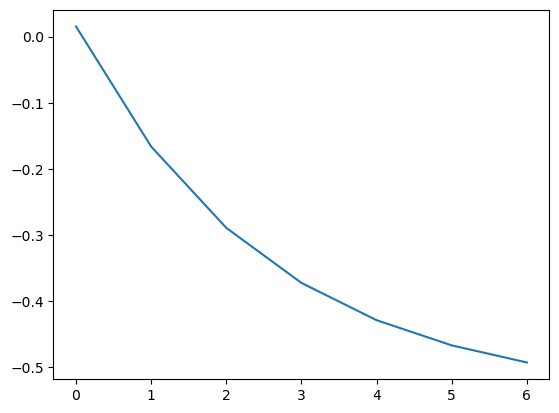

In [59]:
sol_drug_3 = solve_ivp(cnv_compartment, [t_min_1, t_max_1], [start_WT_3, start_CN_3], args=(drug_WTtoCN, drug_CNtoWT),
                dense_output=True)

z_m_3 = sol_drug_3.sol(t_m)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(range(len(z_m_3[1])),z_m_3[1])

In [97]:
z_m_1

array([[0.6       , 0.54699959, 0.51109042, 0.48668959, 0.4704075 ],
       [0.4       , 0.45300041, 0.48890958, 0.51331041, 0.5295925 ]])

In [61]:
print(drug_WTtoCN)
print(drug_CNtoWT)
print(start_WT_2)
print(start_CN_2)

0.22
0.17
-0.4517624747429527
0.5482375252570473


In [63]:
print(drug_WTtoCN)
print(drug_CNtoWT)
print(start_WT)
print(start_CN)

0.22
0.17
0.6000000000000001
0.3999999999999999


In [66]:
1-z_m_1[1][-1]

np.float64(0.4517624747429527)